In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
class MaterialsNN(nn.Module):
    """
    Classical Neural Network for Materials Property Prediction
    Based on the baseline model from the QNN materials informatics paper
    """
    
    def __init__(self, input_size=5, hidden_sizes=[], output_size=1):
        """
        Args:
            input_size: Number of input features (5 for the materials dataset)
            hidden_sizes: List of hidden layer sizes (e.g., [5] for 5-5-1 architecture)
            output_size: Number of output neurons (1 for regression)
        """
        super(MaterialsNN, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Add hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.Sigmoid())  # Sigmoid activation as specified in paper
            prev_size = hidden_size
        
        # Add output layer
        layers.append(nn.Linear(prev_size, output_size))
        
        self.network = nn.Sequential(*layers)
        
        # Count parameters for verification
        self.param_count = sum(p.numel() for p in self.parameters())
        
    def forward(self, x):
        return self.network(x)

def get_model_architectures():
    """
    Returns the four baseline architectures from the paper
    """
    architectures = {
        "5-5-1": {"hidden_sizes": [5], "expected_params": 36},
        "5-3-1": {"hidden_sizes": [3], "expected_params": 22}, 
        "5-2-1": {"hidden_sizes": [2], "expected_params": 15},
        "5-1": {"hidden_sizes": [], "expected_params": 6}
    }
    return architectures

def train_model(model, X_train, y_train, X_val=None, y_val=None, 
                epochs=10000, lr=0.02, l2_weight=1e-4, verbose=False):
    """
    Train the neural network model following the paper's specifications
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_weight)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        # Validation (if provided)
        if X_val is not None and y_val is not None:
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs, y_val)
                val_losses.append(val_loss.item())
        
        if verbose and (epoch + 1) % 1000 == 0:
            if X_val is not None:
                print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}')
            else:
                print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.6f}')
    
    return train_losses, val_losses

def k_fold_cross_validation(X, y, model_config, k=5, **train_kwargs):
    """
    Perform k-fold cross-validation as described in the paper
    """
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []
    
    for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
        print(f"Training fold {fold + 1}/{k}...")
        
        # Split data
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_test_fold = X[test_idx]
        y_test_fold = y[test_idx]
        
        # Create and train model
        model = MaterialsNN(**model_config)
        train_model(model, X_train_fold, y_train_fold, **train_kwargs)
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_fold)
            rmse = torch.sqrt(nn.MSELoss()(y_pred, y_test_fold)).item()
            fold_results.append(rmse)
    
    return fold_results

def prepare_sample_data():
    """
    Create sample data similar to the materials dataset structure
    Features: formation_energy_per_atom, band_gap, density, cati_anio_ratio, dist_from_o
    Target: melting_point (scaled)
    """
    np.random.seed(42)
    n_samples = 70  # Same as in the paper
    
    # Generate synthetic materials data
    X = np.random.randn(n_samples, 5)  # 5 features
    
    # Create a synthetic target with some realistic relationships
    y = (0.3 * X[:, 0] + 0.5 * X[:, 1] + 0.2 * X[:, 2] + 
         0.1 * X[:, 3] + 0.4 * X[:, 4] + 0.1 * np.random.randn(n_samples))
    
    # Normalize features (mean=0, std=1, then scale to [-1, 1])
    scaler_X = StandardScaler()
    X_normalized = scaler_X.fit_transform(X)
    X_scaled = np.clip(X_normalized, -1, 1)  # Ensure range [-1, 1]
    
    # Scale target (divide by 3500 as mentioned in paper)
    y_scaled = y / 3500
    
    return torch.FloatTensor(X_scaled), torch.FloatTensor(y_scaled.reshape(-1, 1))

In [3]:
def main():
    """
    Reproduce the baseline experiments from the paper
    """
    print("Classical NN Baseline - Materials Property Prediction")
    print("=" * 50)
    
    # Prepare data
    X, y = prepare_sample_data()
    print(f"Dataset shape: {X.shape}, Target shape: {y.shape}")
    
    # Get model architectures
    architectures = get_model_architectures()
    
    results = {}
    
    for arch_name, config in architectures.items():
        print(f"\nTesting architecture: {arch_name}")
        print("-" * 30)
        
        # Create model and verify parameter count
        model = MaterialsNN(hidden_sizes=config["hidden_sizes"])
        print(f"Expected parameters: {config['expected_params']}")
        print(f"Actual parameters: {model.param_count}")
        
        # Perform k-fold cross-validation
        fold_rmses = k_fold_cross_validation(
            X, y, 
            {"hidden_sizes": config["hidden_sizes"]},
            k=5,
            epochs=10000,
            lr=0.02,
            l2_weight=1e-4,
            verbose=False
        )
        
        mean_rmse = np.mean(fold_rmses)
        std_rmse = np.std(fold_rmses)
        
        results[arch_name] = {
            "fold_rmses": fold_rmses,
            "mean_rmse": mean_rmse,
            "std_rmse": std_rmse,
            "param_count": model.param_count
        }
        
        print(f"Cross-validation RMSE: {mean_rmse:.6f} ± {std_rmse:.6f}")
        print(f"Individual fold RMSEs: {[f'{rmse:.6f}' for rmse in fold_rmses]}")
    
    # Summary
    print("\n" + "=" * 50)
    print("SUMMARY OF RESULTS")
    print("=" * 50)
    print(f"{'Architecture':<10} {'Parameters':<12} {'Mean RMSE':<12} {'Std RMSE':<12}")
    print("-" * 50)
    
    for arch_name, result in results.items():
        print(f"{arch_name:<10} {result['param_count']:<12} "
              f"{result['mean_rmse']:<12.6f} {result['std_rmse']:<12.6f}")


In [4]:
def example_single_model():
    """
    Example of training a single model
    """
    print("\nExample: Training single 5-5-1 model")
    print("-" * 40)
    
    X, y = prepare_sample_data()
    
    # Split data manually for demonstration
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Create and train model
    model = MaterialsNN(hidden_sizes=[5])  # 5-5-1 architecture
    print(f"Model has {model.param_count} parameters")
    
    train_losses, _ = train_model(
        model, X_train, y_train, X_test, y_test,
        epochs=1000, lr=0.02, l2_weight=1e-4, verbose=True
    )
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train)
        test_pred = model(X_test)
        
        train_rmse = torch.sqrt(nn.MSELoss()(train_pred, y_train)).item()
        test_rmse = torch.sqrt(nn.MSELoss()(test_pred, y_test)).item()
        
        print(f"\nFinal Results:")
        print(f"Training RMSE: {train_rmse:.6f}")
        print(f"Test RMSE: {test_rmse:.6f}")
        print(f"Generalization gap: {test_rmse - train_rmse:.6f}")

def plot_loss(train_losses, val_losses=None):
    """
    Plot training and validation loss
    """
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    if val_losses is not None:
        plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [7]:
data = pd.read_csv("data.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   mpid                          70 non-null     object 
 1   formula_pretty                70 non-null     object 
 2   tmelt_C                       70 non-null     float64
 3   formation_energy_per_atom_eV  70 non-null     float64
 4   band_gap_eV                   70 non-null     float64
 5   density_g_cm3                 70 non-null     float64
 6   cati_anio_ratio               70 non-null     float64
 7   dist_from_o_A                 70 non-null     float64
 8    Ref                          70 non-null     object 
dtypes: float64(6), object(3)
memory usage: 5.1+ KB


,mpid,formula_pretty,tmelt_C,formation_energy_per_atom_eV,band_gap_eV,density_g_cm3,cati_anio_ratio,dist_from_o_A,Ref
0,mp-353,Ag20,230.0,-0.322979,0.0000,7.163038,2.000000,2.058538,S1
1,mp-1143,A|203,2025.0,-3.427314,5.8537,3.873499,0.666667,1.989267,S1
2,mp-306,B203,450.0,-2.798820,6.3017,2.561903,0.666667,1.370723,S1
3,mp-1342,BaO,1923.0,-2.824279,2.0906,5.859230,1.000000,2.790392,S1
4,mp-2542,BeO,2400.0,-3.103492,7.4639,3.019437,1.000000,2.684602,S1


In [8]:
feature_cols = [
 'formation_energy_per_atom_eV',
 'band_gap_eV',
 'density_g_cm3',
 'cati_anio_ratio',
 'dist_from_o_A']

target_col = 'tmelt_C'

X_raw = data[feature_cols].values
y_raw = data[target_col].values

scaler_X = StandardScaler()
X_norm = scaler_X.fit_transform(X_raw)

In [9]:
X_scaled = X_norm / np.max(np.abs(X_norm), axis=0)

for i in  y_raw:
    i = float(i)
y_scaled = (y_raw / 3500.0) * 2 - 1

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

In [12]:
MatNN = MaterialsNN(input_size= 5, hidden_sizes=[5], output_size=1)
# Convert numpy arrays to torch tensors with proper shape adjustments
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train.reshape(-1, 1))
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test.reshape(-1, 1))

train_losses, _ = train_model(
        MatNN, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
        epochs=1000, lr=0.02, l2_weight=1e-4, verbose=True
    )

Epoch [1000/1000], Train Loss: 0.013224, Val Loss: 0.046468


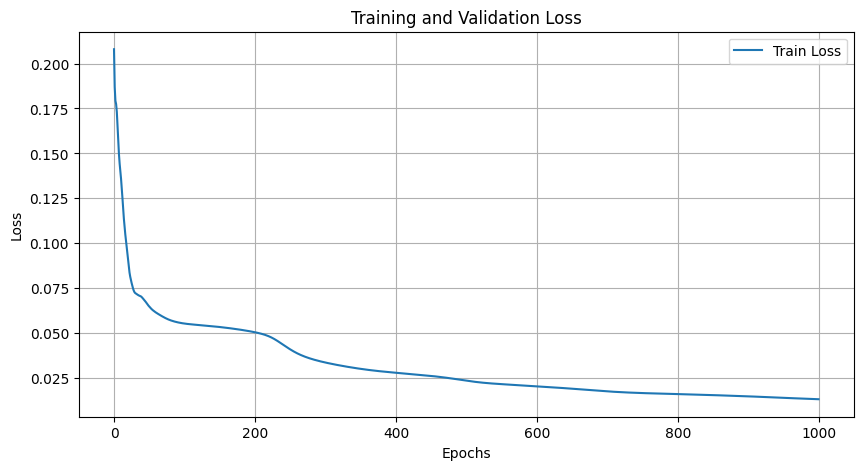

In [13]:
plot_loss(train_losses)

In [19]:
if True:
    # Final evaluation
    MatNN.eval()
    with torch.no_grad():
        train_pred = MatNN(X_train_tensor)
        test_pred = MatNN(X_test_tensor)

        train_rmse = torch.sqrt(nn.MSELoss()(train_pred, y_train_tensor)).item()
        test_rmse = torch.sqrt(nn.MSELoss()(test_pred, y_test_tensor)).item()

        print(f"\nFinal Results:")
        print(f"Training RMSE: {train_rmse:.6f}")
        print(f"Test RMSE: {test_rmse:.6f}")
        print(f"Generalization gap: {test_rmse - train_rmse:.6f}")


Final Results:
Training RMSE: 0.114936
Test RMSE: 0.215564
Generalization gap: 0.100628
